# Import Libraries

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [5]:
!pip install albumentations

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [6]:
# Train Phase transformations
from albumentations import Compose, HorizontalFlip, Normalize, Resize,Blur
import albumentations as album
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np

mean, std = ( 0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
train_transforms = Compose([album.HorizontalFlip(p=0.5),
                            album.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       album.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.01,rotate_limit=30, p=0.5, border_mode = cv2.BORDER_REPLICATE),
                                       album.augmentations.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1,
                                                           min_height=16, min_width=16, fill_value=mean, mask_fill_value = None),
                                       Normalize(mean,std),
                                       ToTensorV2()
                                       ])

# Test Phase transformations
test_transforms = Compose([Normalize(mean,std),ToTensorV2()])


# Dataset and Creating Train/Test Split

In [7]:
traindata = datasets.CIFAR10('./data', train=True, download=True)
testdata = datasets.CIFAR10('./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Apply Albumentations transforms using a Lambda wrapper
traindata.transform = transforms.Compose([
    transforms.Lambda(lambda x: train_transforms(image=np.array(x))['image'])
])

testdata.transform = transforms.Compose([
    transforms.Lambda(lambda x: test_transforms(image=np.array(x))['image'])
])

In [9]:
traindata.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Dataloader Arguments & Test/Train Dataloaders


In [10]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

# train dataloader
train_loader = torch.utils.data.DataLoader(traindata, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(testdata, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [11]:
#The inverse normalization should be
# x   = z*sigma + mean
#     = (z + mean/sigma) * sigma
#     = (z - (-mean/sigma)) / (1/sigma),
#     since the normalization process is actually z = (x - mean) / sigma if you look carefully at the documentation of transforms.Normalize.

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: 153600000
torch.Size([128, 3, 32, 32])
torch.Size([128])
ship


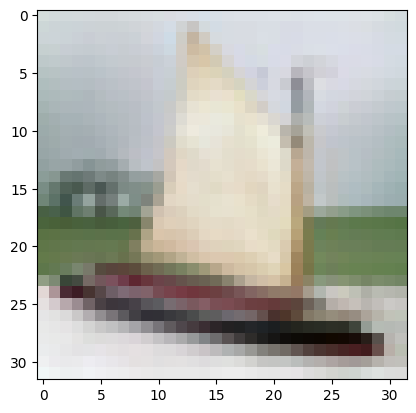

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
import numpy as np
train_data = traindata.data

print('[Train]')
print(' - Numpy Shape:', traindata.data.shape)
print(' - Tensor Shape:', traindata.data.size)

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

plt.imshow(np.transpose(inv_normalize(images[0]), (1, 2, 0)))
print(traindata.classes[labels[0]])


It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

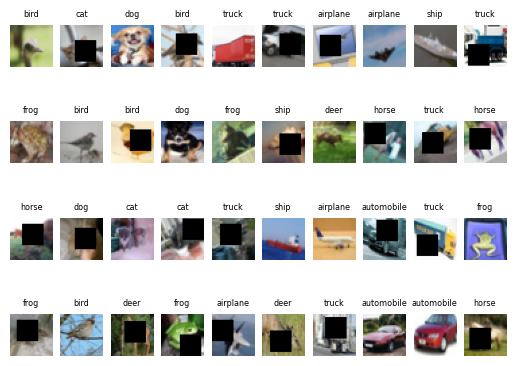

In [ ]:
figure = plt.figure()
num_of_images = 40


for index in range(1, num_of_images + 1):
    plt.subplot(4, 10, index)
    plt.axis('off')
    image= inv_normalize(images[index])
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.title(traindata.classes[labels[index]],size='xx-small')

# Model Skeleton For all Normalization

In [12]:
from utils import *
from model import *

In [13]:
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 34, 34]             864
       BatchNorm2d-2           [-1, 32, 34, 34]              64
              ReLU-3           [-1, 32, 34, 34]               0
           Dropout-4           [-1, 32, 34, 34]               0
            Conv2d-5           [-1, 64, 36, 36]          18,432
       BatchNorm2d-6           [-1, 64, 36, 36]             128
              ReLU-7           [-1, 64, 36, 36]               0
           Dropout-8           [-1, 64, 36, 36]               0
            Conv2d-9           [-1, 64, 18, 18]          36,864
      BatchNorm2d-10           [-1, 64, 18, 18]             128
             ReLU-11           [-1, 64, 18, 18]               0
          Dropout-12           [-1, 64, 18, 18]               0
           Conv2d-13           [-1, 64, 18, 18]             576
           Conv2d-14           [-1, 32,

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min',patience=2,verbose=True,min_lr=0.0001,factor=0.2)
EPOCHS = 50

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step(test_losses[-1])

EPOCH: 0


Loss=1.6179132461547852 Batch_id=390 Accuracy=35.01: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s]



Test set: Average loss: 1.4364, Accuracy: 4825/10000 (48.25%)

EPOCH: 1


Loss=1.1233232021331787 Batch_id=390 Accuracy=47.58: 100%|██████████| 391/391 [00:24<00:00, 16.17it/s]



Test set: Average loss: 1.1556, Accuracy: 5844/10000 (58.44%)

EPOCH: 2


Loss=1.2674896717071533 Batch_id=390 Accuracy=53.25: 100%|██████████| 391/391 [00:23<00:00, 16.44it/s]



Test set: Average loss: 1.0891, Accuracy: 6091/10000 (60.91%)

EPOCH: 3


Loss=1.0267335176467896 Batch_id=390 Accuracy=57.01: 100%|██████████| 391/391 [00:24<00:00, 15.67it/s]



Test set: Average loss: 0.9460, Accuracy: 6656/10000 (66.56%)

EPOCH: 4


Loss=1.0293132066726685 Batch_id=390 Accuracy=60.25: 100%|██████████| 391/391 [00:25<00:00, 15.47it/s]



Test set: Average loss: 0.8575, Accuracy: 6996/10000 (69.96%)

EPOCH: 5


Loss=0.8232982754707336 Batch_id=390 Accuracy=62.55: 100%|██████████| 391/391 [00:23<00:00, 16.96it/s]



Test set: Average loss: 0.8369, Accuracy: 7065/10000 (70.65%)

EPOCH: 6


Loss=1.0340496301651 Batch_id=390 Accuracy=64.34: 100%|██████████| 391/391 [00:23<00:00, 16.88it/s]



Test set: Average loss: 0.7979, Accuracy: 7269/10000 (72.69%)

EPOCH: 7


Loss=0.8445004224777222 Batch_id=390 Accuracy=65.71: 100%|██████████| 391/391 [00:24<00:00, 15.88it/s]



Test set: Average loss: 0.7435, Accuracy: 7464/10000 (74.64%)

EPOCH: 8


Loss=0.9789436459541321 Batch_id=390 Accuracy=66.83: 100%|██████████| 391/391 [00:25<00:00, 15.29it/s]



Test set: Average loss: 0.7140, Accuracy: 7535/10000 (75.35%)

EPOCH: 9


Loss=0.8532012104988098 Batch_id=390 Accuracy=67.73: 100%|██████████| 391/391 [00:24<00:00, 15.83it/s]



Test set: Average loss: 0.6873, Accuracy: 7661/10000 (76.61%)

EPOCH: 10


Loss=1.0176955461502075 Batch_id=390 Accuracy=69.14: 100%|██████████| 391/391 [00:23<00:00, 16.71it/s]



Test set: Average loss: 0.6608, Accuracy: 7730/10000 (77.30%)

EPOCH: 11


Loss=0.9574605226516724 Batch_id=390 Accuracy=69.69: 100%|██████████| 391/391 [00:23<00:00, 16.35it/s]



Test set: Average loss: 0.7011, Accuracy: 7582/10000 (75.82%)

EPOCH: 12


Loss=0.8793613314628601 Batch_id=390 Accuracy=70.32: 100%|██████████| 391/391 [00:25<00:00, 15.34it/s]



Test set: Average loss: 0.6336, Accuracy: 7817/10000 (78.17%)

EPOCH: 13


Loss=0.7429414987564087 Batch_id=390 Accuracy=70.78: 100%|██████████| 391/391 [00:26<00:00, 14.70it/s]



Test set: Average loss: 0.6127, Accuracy: 7927/10000 (79.27%)

EPOCH: 14


Loss=0.7018397450447083 Batch_id=390 Accuracy=71.47: 100%|██████████| 391/391 [00:24<00:00, 15.96it/s]



Test set: Average loss: 0.5752, Accuracy: 8022/10000 (80.22%)

EPOCH: 15


Loss=0.6909226775169373 Batch_id=390 Accuracy=71.90: 100%|██████████| 391/391 [00:23<00:00, 16.90it/s]



Test set: Average loss: 0.5654, Accuracy: 8052/10000 (80.52%)

EPOCH: 16


Loss=0.8359844088554382 Batch_id=390 Accuracy=72.58: 100%|██████████| 391/391 [00:25<00:00, 15.50it/s]



Test set: Average loss: 0.5715, Accuracy: 8044/10000 (80.44%)

EPOCH: 17


Loss=0.9264951944351196 Batch_id=390 Accuracy=72.99: 100%|██████████| 391/391 [00:24<00:00, 16.14it/s]



Test set: Average loss: 0.5321, Accuracy: 8185/10000 (81.85%)

EPOCH: 18


Loss=0.7289019823074341 Batch_id=390 Accuracy=73.48: 100%|██████████| 391/391 [00:25<00:00, 15.52it/s]



Test set: Average loss: 0.5819, Accuracy: 8034/10000 (80.34%)

EPOCH: 19


Loss=0.7532680630683899 Batch_id=390 Accuracy=73.72: 100%|██████████| 391/391 [00:26<00:00, 14.62it/s]



Test set: Average loss: 0.5273, Accuracy: 8205/10000 (82.05%)

EPOCH: 20


Loss=0.640470564365387 Batch_id=390 Accuracy=74.02: 100%|██████████| 391/391 [00:24<00:00, 16.02it/s]



Test set: Average loss: 0.5415, Accuracy: 8130/10000 (81.30%)

EPOCH: 21


Loss=0.9456552267074585 Batch_id=390 Accuracy=74.59: 100%|██████████| 391/391 [00:23<00:00, 17.00it/s]



Test set: Average loss: 0.5089, Accuracy: 8273/10000 (82.73%)

EPOCH: 22


Loss=0.7517733573913574 Batch_id=390 Accuracy=74.61: 100%|██████████| 391/391 [00:23<00:00, 16.30it/s]



Test set: Average loss: 0.5946, Accuracy: 8038/10000 (80.38%)

EPOCH: 23


Loss=0.6796274781227112 Batch_id=390 Accuracy=75.04: 100%|██████████| 391/391 [00:24<00:00, 15.64it/s]



Test set: Average loss: 0.5058, Accuracy: 8288/10000 (82.88%)

EPOCH: 24


Loss=0.7975629568099976 Batch_id=390 Accuracy=75.33: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s]



Test set: Average loss: 0.4990, Accuracy: 8314/10000 (83.14%)

EPOCH: 25


Loss=0.7200419902801514 Batch_id=390 Accuracy=75.41: 100%|██████████| 391/391 [00:23<00:00, 16.80it/s]



Test set: Average loss: 0.4873, Accuracy: 8370/10000 (83.70%)

EPOCH: 26


Loss=0.638790488243103 Batch_id=390 Accuracy=75.62: 100%|██████████| 391/391 [00:23<00:00, 16.93it/s]



Test set: Average loss: 0.4804, Accuracy: 8376/10000 (83.76%)

EPOCH: 27


Loss=0.6524671316146851 Batch_id=390 Accuracy=76.22: 100%|██████████| 391/391 [00:24<00:00, 16.02it/s]



Test set: Average loss: 0.4551, Accuracy: 8416/10000 (84.16%)

EPOCH: 28


Loss=0.7420953512191772 Batch_id=390 Accuracy=76.33: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s]



Test set: Average loss: 0.4738, Accuracy: 8414/10000 (84.14%)

EPOCH: 29


Loss=0.7734965085983276 Batch_id=390 Accuracy=76.42: 100%|██████████| 391/391 [00:25<00:00, 15.50it/s]



Test set: Average loss: 0.4622, Accuracy: 8424/10000 (84.24%)

EPOCH: 30


Loss=0.865139365196228 Batch_id=390 Accuracy=76.52: 100%|██████████| 391/391 [00:23<00:00, 16.54it/s]



Test set: Average loss: 0.4665, Accuracy: 8421/10000 (84.21%)

Epoch 00031: reducing learning rate of group 0 to 2.0000e-03.
EPOCH: 31


Loss=0.44467559456825256 Batch_id=390 Accuracy=78.52: 100%|██████████| 391/391 [00:23<00:00, 16.80it/s]



Test set: Average loss: 0.4116, Accuracy: 8606/10000 (86.06%)

EPOCH: 32


Loss=0.5711318850517273 Batch_id=390 Accuracy=78.83: 100%|██████████| 391/391 [00:24<00:00, 16.23it/s]



Test set: Average loss: 0.4087, Accuracy: 8629/10000 (86.29%)

EPOCH: 33


Loss=0.8289307355880737 Batch_id=390 Accuracy=78.95: 100%|██████████| 391/391 [00:24<00:00, 15.69it/s]



Test set: Average loss: 0.4060, Accuracy: 8629/10000 (86.29%)

EPOCH: 34


Loss=0.44654911756515503 Batch_id=390 Accuracy=79.21: 100%|██████████| 391/391 [00:24<00:00, 15.82it/s]



Test set: Average loss: 0.3980, Accuracy: 8640/10000 (86.40%)

EPOCH: 35


Loss=0.6142492294311523 Batch_id=390 Accuracy=79.23: 100%|██████████| 391/391 [00:23<00:00, 16.81it/s]



Test set: Average loss: 0.3979, Accuracy: 8633/10000 (86.33%)

EPOCH: 36


Loss=0.5702794194221497 Batch_id=390 Accuracy=79.50: 100%|██████████| 391/391 [00:23<00:00, 16.96it/s]



Test set: Average loss: 0.3969, Accuracy: 8671/10000 (86.71%)

EPOCH: 37


Loss=0.6839883327484131 Batch_id=390 Accuracy=79.47: 100%|██████████| 391/391 [00:24<00:00, 15.87it/s]



Test set: Average loss: 0.3948, Accuracy: 8661/10000 (86.61%)

EPOCH: 38


Loss=0.6878381967544556 Batch_id=390 Accuracy=79.46: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s]



Test set: Average loss: 0.4043, Accuracy: 8619/10000 (86.19%)

EPOCH: 39


Loss=0.5051772594451904 Batch_id=390 Accuracy=79.49: 100%|██████████| 391/391 [00:25<00:00, 15.09it/s]



Test set: Average loss: 0.3932, Accuracy: 8649/10000 (86.49%)

EPOCH: 40


Loss=0.6042853593826294 Batch_id=390 Accuracy=79.71: 100%|██████████| 391/391 [00:22<00:00, 17.01it/s]



Test set: Average loss: 0.3919, Accuracy: 8656/10000 (86.56%)

EPOCH: 41


Loss=0.9076387286186218 Batch_id=390 Accuracy=79.84: 100%|██████████| 391/391 [00:23<00:00, 16.53it/s]



Test set: Average loss: 0.3972, Accuracy: 8659/10000 (86.59%)

EPOCH: 42


Loss=0.6518163084983826 Batch_id=390 Accuracy=79.70: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s]



Test set: Average loss: 0.3964, Accuracy: 8674/10000 (86.74%)

EPOCH: 43


Loss=0.5108073949813843 Batch_id=390 Accuracy=79.71: 100%|██████████| 391/391 [00:24<00:00, 16.05it/s]



Test set: Average loss: 0.3928, Accuracy: 8661/10000 (86.61%)

Epoch 00044: reducing learning rate of group 0 to 4.0000e-04.
EPOCH: 44


Loss=0.5123001337051392 Batch_id=390 Accuracy=80.14: 100%|██████████| 391/391 [00:24<00:00, 15.90it/s]



Test set: Average loss: 0.3841, Accuracy: 8700/10000 (87.00%)

EPOCH: 45


Loss=0.5996276140213013 Batch_id=390 Accuracy=80.32: 100%|██████████| 391/391 [00:24<00:00, 15.83it/s]



Test set: Average loss: 0.3825, Accuracy: 8705/10000 (87.05%)

EPOCH: 46


Loss=0.57126784324646 Batch_id=390 Accuracy=80.18: 100%|██████████| 391/391 [00:23<00:00, 16.92it/s]



Test set: Average loss: 0.3829, Accuracy: 8719/10000 (87.19%)

EPOCH: 47


Loss=0.5879080295562744 Batch_id=390 Accuracy=80.43: 100%|██████████| 391/391 [00:22<00:00, 17.02it/s]



Test set: Average loss: 0.3809, Accuracy: 8715/10000 (87.15%)

EPOCH: 48


Loss=0.5796209573745728 Batch_id=390 Accuracy=80.32: 100%|██████████| 391/391 [00:23<00:00, 16.63it/s]



Test set: Average loss: 0.3800, Accuracy: 8713/10000 (87.13%)

EPOCH: 49


Loss=0.7996807098388672 Batch_id=390 Accuracy=80.43: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s]



Test set: Average loss: 0.3813, Accuracy: 8720/10000 (87.20%)



In [15]:
torch.save(model, "./modelDilation")

Text(0.5, 1.0, 'Test Accuracy')

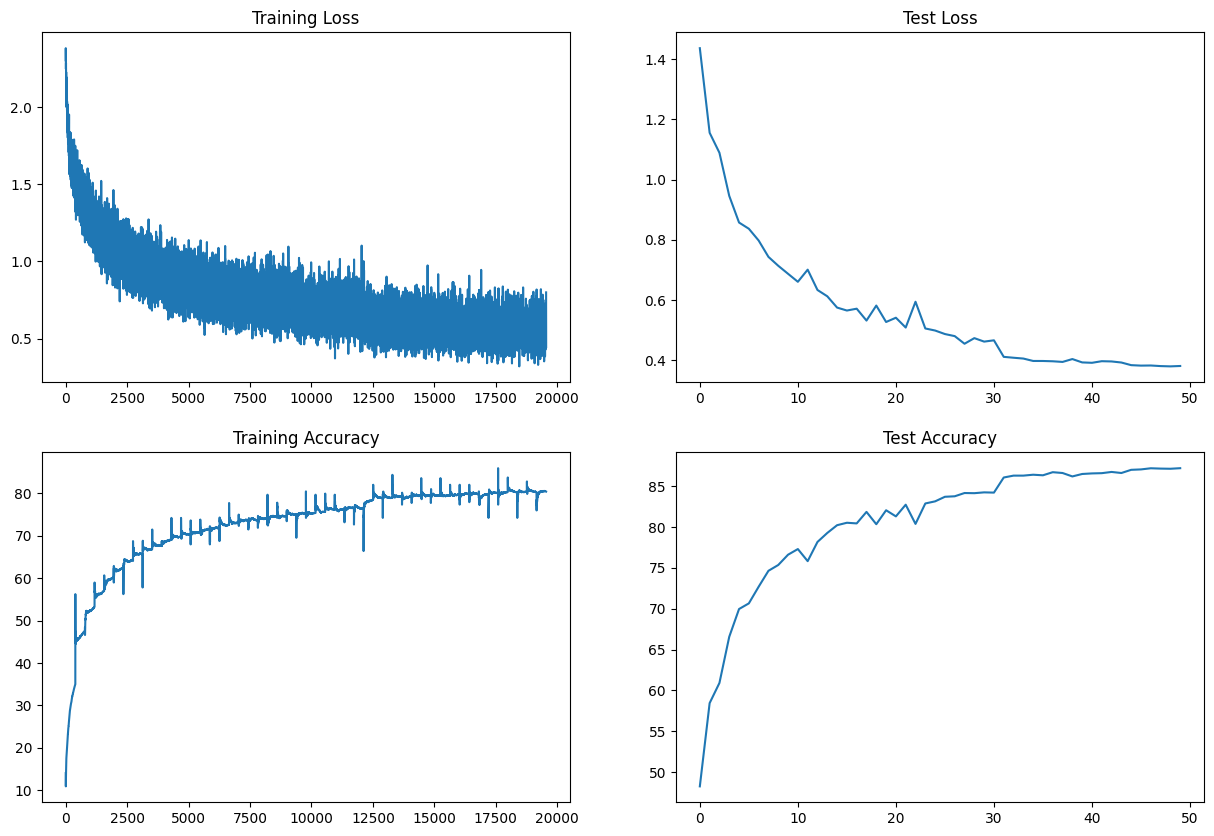

In [16]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")